#### Imports

In [55]:
# Patching Analysis: Word Counting Task (internal running count representations)
# (Falcon-7B-Instruct or Mistral-7B-Instruct-v0.3) 

import pandas as pd
import numpy as np
import json

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from nnsight import LanguageModel

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

from tqdm import tqdm
import random

from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

print("Libraries loaded successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Libraries loaded successfully!
PyTorch version: 2.7.0+cu118
CUDA available: True


#### Load model

In [2]:
print("Loading model with NNsight...")

# Load model (NNsight handles device placement automatically)
model = LanguageModel("tiiuae/Falcon3-7B-Instruct")
# model = LanguageModel("mistralai/Mistral-7B-Instruct-v0.3")

print("✓ Model loaded successfully!")

Loading model with NNsight...
✓ Model loaded successfully!


#### Test model

In [3]:
# Test basic functionality
test_prompt = "Count the number of words in the following list that match the given type, and put the numerical answer in parentheses.\n    Type: fruits\n    List: [apple book cherry chair]\n    Answer: ("

print(f"\nTest prompt: {test_prompt}")

# Test model generation and show response
with model.generate(test_prompt, max_new_tokens=5, scan=False, validate=False, pad_token_id=model.tokenizer.eos_token_id) as tracer:
    output = model.generator.output.save()


Test prompt: Count the number of words in the following list that match the given type, and put the numerical answer in parentheses.
    Type: fruits
    List: [apple book cherry chair]
    Answer: (


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
# Extract and display the response
if hasattr(output, 'value'):
    tokens = output.value
else:
    tokens = output

if hasattr(tokens, 'cpu'):
    tokens = tokens.cpu()

if torch.is_tensor(tokens):
    token_list = tokens.tolist()
    if isinstance(token_list[0], list):
        token_list = token_list[0]
else:
    token_list = tokens

response = model.tokenizer.decode(token_list, skip_special_tokens=True)
print(f"Model response: {response}")

Model response: Count the number of words in the following list that match the given type, and put the numerical answer in parentheses.
    Type: fruits
    List: [apple book cherry chair]
    Answer: (2)
    <


In [5]:
# Extract just the generated part (after the prompt)
generated_part = response[len(test_prompt):] if len(response) > len(test_prompt) else ""
print(f"Generated text: '{generated_part}'")

print("✓ Model generation test successful!")

Generated text: '2)
    <'
✓ Model generation test successful!


#### Generate control datasets

In [9]:
# Define our controlled vocabulary
CATEGORIES = {
    'fruits': ['apple', 'banana', 'orange', 'grape', 'strawberry', 'pineapple', 'mango', 'cherry', 'peach', 'watermelon'],
    'cities': ['Paris', 'Tokyo', 'London', 'Sydney', 'Cairo', 'Mumbai', 'Toronto', 'Berlin', 'Rio', 'Bangkok'],
    'animals': ['dog', 'cat', 'elephant', 'tiger', 'rabbit', 'horse', 'dolphin', 'eagle', 'snake', 'penguin'],
    'sports': ['soccer', 'basketball', 'tennis', 'swimming', 'baseball', 'golf', 'hockey', 'volleyball', 'boxing', 'cycling'],
    'professions': ['doctor', 'teacher', 'engineer', 'lawyer', 'chef', 'nurse', 'pilot', 'mechanic', 'architect', 'firefighter'],
}

# Non-target words (neutral items)
NEUTRAL_WORDS = ['chair', 'computer', 'book', 'mirror', 'clock', 'bicycle', 'phone', 'lamp', 'bottle', 'keyboard']

In [10]:
def create_prompt(example):
    """Create a formatted prompt for the word counting task"""
    list_str = " ".join(example['list'])
    
    prompt = f"""Count the number of words in the following list that match the given type, and put the numerical answer in parentheses.
    Type: {example['type']}
    List: [{list_str}]
    Answer: ("""
    
    return prompt

In [11]:
def create_sequence_with_fixed_positions(target_category, target_positions, total_length=6, seed_offset=0):
    """Create a sequence with target words at specified positions"""
    
    local_random = random.Random(42 + seed_offset)
    
    # Initialize sequence with None
    sequence = [None] * total_length
    
    # Place target words at specified positions
    target_words = local_random.sample(CATEGORIES[target_category], len(target_positions))
    for i, pos in enumerate(target_positions):
        sequence[pos] = target_words[i]
    
    # Fill remaining positions with neutral words
    remaining_positions = [i for i in range(total_length) if sequence[i] is None]
    neutral_words = local_random.sample(NEUTRAL_WORDS, len(remaining_positions))
    
    for i, pos in enumerate(remaining_positions):
        sequence[pos] = neutral_words[i]
    
    return {
        'type': target_category,
        'list': sequence,
        'answer': len(target_positions)  # Always 3 target items
    }

In [19]:
def generate_controlled_dataset():
    """Generate controlled dataset with sequences A and B for each condition"""
    
    category_names = list(CATEGORIES.keys())
    
    # Define position patterns for each condition
    position_patterns = {
        'positive_control_1': {
            'sequence_A_positions': [0, 2, 4],
            'sequence_B_positions': [0, 2, 4],
            'description': 'A: [0,2,4], B: [0,2,4] - same positions'
        },
        'positive_control_2': {
            'sequence_A_positions': [0, 2, 4],
            'sequence_B_positions': [1, 3, 5],
            'description': 'A: [0,2,4], B: [1,3,5] - different positions'
        },
        'negative_control_1': {
            'sequence_A_positions': [0, 1, 2],
            'sequence_B_positions': [3, 4, 5],
            'description': 'A: [0,1,2], B: [3,4,5] - different positions'
        },
        'negative_control_2': {
            'sequence_A_positions': [0, 1, 2],
            'sequence_B_positions': [3, 4, 5],
            'description': 'A: [0,1,2], B: [3,4,5] - different positions'
        }
    }
    
    all_data = []
    record_id = 0
    
    for condition_type, pattern in position_patterns.items():
        print(f"Generating {condition_type}: {pattern['description']}")
        
        # For each category A
        for category_A in category_names:
            # Pair with each other category B (exactly once)
            for category_B in category_names:
                if category_A != category_B:
                    
                    # Create unique seeds for this A→B combination
                    seed_A = record_id * 100
                    seed_B = record_id * 100 + 50
                    
                    # Generate sequence A
                    sequence_A = create_sequence_with_fixed_positions(
                        category_A,
                        pattern['sequence_A_positions'],
                        seed_offset=seed_A
                    )
                    
                    # Generate sequence B  
                    sequence_B = create_sequence_with_fixed_positions(
                        category_B,
                        pattern['sequence_B_positions'],
                        seed_offset=seed_B
                    )
                    
                    # Create data record
                    data_record = {
                        'record_id': record_id,
                        'condition': condition_type,
                        'category_A': category_A,
                        'category_B': category_B,
                        'sequence_A': sequence_A,
                        'sequence_B': sequence_B,
                        'sequence_A_positions': pattern['sequence_A_positions'],
                        'sequence_B_positions': pattern['sequence_B_positions'],
                        'prompt_A': create_prompt(sequence_A),
                        'prompt_B': create_prompt(sequence_B)
                    }
                    
                    all_data.append(data_record)
                    record_id += 1
    
    return all_data

In [20]:
# Generate the controlled dataset
print("Generating controlled dataset with sequences A and B...")
controlled_dataset = generate_controlled_dataset()

# Print summary
print(f"\n=== CONTROLLED DATASET SUMMARY ===")
print(f"Total records: {len(controlled_dataset)}")

Generating controlled dataset with sequences A and B...
Generating positive_control_1: A: [0,2,4], B: [0,2,4] - same positions
Generating positive_control_2: A: [0,2,4], B: [1,3,5] - different positions
Generating negative_control_1: A: [0,1,2], B: [3,4,5] - different positions
Generating negative_control_2: A: [0,1,2], B: [3,4,5] - different positions

=== CONTROLLED DATASET SUMMARY ===
Total records: 80


In [21]:
# Summary by condition
condition_counts = {}
for record in controlled_dataset:
    condition = record['condition']
    condition_counts[condition] = condition_counts.get(condition, 0) + 1

for condition, count in condition_counts.items():
    print(f"{condition}: {count} pairs")

positive_control_1: 20 pairs
positive_control_2: 20 pairs
negative_control_1: 20 pairs
negative_control_2: 20 pairs


In [22]:
# Show examples
print(f"\n=== EXAMPLES ===")
for condition in ['positive_control_1', 'positive_control_2', 'negative_control_1', 'negative_control_2']:
    example = next(record for record in controlled_dataset if record['condition'] == condition)
    print(f"\n{condition}:")
    print(f"  Category A: {example['category_A']}, positions {example['sequence_A_positions']}")
    print(f"  Sequence A: {example['sequence_A']['list']}")
    print(f"  Category B: {example['category_B']}, positions {example['sequence_B_positions']}")
    print(f"  Sequence B: {example['sequence_B']['list']}")


=== EXAMPLES ===

positive_control_1:
  Category A: fruits, positions [0, 2, 4]
  Sequence A: ['banana', 'mirror', 'apple', 'keyboard', 'strawberry', 'book']
  Category B: cities, positions [0, 2, 4]
  Sequence B: ['Toronto', 'computer', 'Rio', 'bottle', 'Cairo', 'lamp']

positive_control_2:
  Category A: fruits, positions [0, 2, 4]
  Sequence A: ['pineapple', 'clock', 'grape', 'computer', 'orange', 'phone']
  Category B: cities, positions [1, 3, 5]
  Sequence B: ['bicycle', 'Toronto', 'bottle', 'Bangkok', 'keyboard', 'Sydney']

negative_control_1:
  Category A: fruits, positions [0, 1, 2]
  Sequence A: ['watermelon', 'apple', 'orange', 'book', 'chair', 'phone']
  Category B: cities, positions [3, 4, 5]
  Sequence B: ['mirror', 'bottle', 'book', 'Bangkok', 'Sydney', 'Tokyo']

negative_control_2:
  Category A: fruits, positions [0, 1, 2]
  Sequence A: ['orange', 'apple', 'cherry', 'mirror', 'computer', 'lamp']
  Category B: cities, positions [3, 4, 5]
  Sequence B: ['lamp', 'phone', 'b

In [23]:
# Save to JSONL file
output_filename = 'controlled_counting_dataset.jsonl'
print(f"\nSaving dataset to {output_filename}...")

with open(output_filename, 'w') as f:
    for record in controlled_dataset:
        f.write(json.dumps(record) + '\n')

print(f"✅ Dataset saved to {output_filename}")


Saving dataset to controlled_counting_dataset.jsonl...
✅ Dataset saved to controlled_counting_dataset.jsonl


In [24]:
# Verify file was saved correctly
with open(output_filename, 'r') as f:
    first_line = f.readline()
    loaded_record = json.loads(first_line)

print(f"\n=== FILE VERIFICATION ===")
print(f"First record loaded successfully:")
print(f"  Record ID: {loaded_record['record_id']}")
print(f"  Condition: {loaded_record['condition']}")
print(f"  Categories: {loaded_record['category_A']} → {loaded_record['category_B']}")


=== FILE VERIFICATION ===
First record loaded successfully:
  Record ID: 0
  Condition: positive_control_1
  Categories: fruits → cities


In [25]:
# Create list of all unique sequences for benchmarking
all_sequences = []
for record in controlled_dataset:
    all_sequences.append(record['sequence_A'])
    all_sequences.append(record['sequence_B'])

print(f"\nTotal sequences for benchmarking: {len(all_sequences)}")
print(f"All sequences have 3 target items and 3 neutral items (length 6)")

print(f"\n✅ Controlled dataset generation complete!")


Total sequences for benchmarking: 160
All sequences have 3 target items and 3 neutral items (length 6)

✅ Controlled dataset generation complete!


#### Collect clean responses and activations for all sequences

In [26]:
def extract_answer_from_output(model, output):
    """Extract numerical answer from model output"""
    if hasattr(output, 'value'):
        tokens = output.value
    else:
        tokens = output
        
    if hasattr(tokens, 'cpu'):
        tokens = tokens.cpu()
    
    if torch.is_tensor(tokens):
        token_list = tokens.tolist()
        if isinstance(token_list[0], list):
            token_list = token_list[0]
    else:
        token_list = tokens
    
    response = model.tokenizer.decode(token_list, skip_special_tokens=True)
    
    import re
    prompt_end = response.find("Answer: (")
    if prompt_end != -1:
        answer_part = response[prompt_end + len("Answer: ("):]
        match = re.search(r'^(\d+)', answer_part)
        if match:
            return int(match.group(1)), response
    
    return -1, response

In [27]:
def collect_clean_responses_and_activations(model, dataset_file='controlled_counting_dataset.jsonl'):
    """Collect clean responses and activations for all sequences"""
    
    # Load dataset
    print(f"Loading dataset from {dataset_file}...")
    with open(dataset_file, 'r') as f:
        dataset = [json.loads(line) for line in f]
    
    print(f"Loaded {len(dataset)} records")
    
    # Prepare results storage
    response_results = []
    activation_results = []
    
    total_sequences = len(dataset) * 2  # A and B sequences
    processed = 0
    
    print(f"Processing {total_sequences} sequences...")
    
    for record in tqdm(dataset, desc="Processing records"):
        record_id = record['record_id']
        condition = record['condition']
        
        # Process Sequence A
        sequence_A = record['sequence_A']
        prompt_A = record['prompt_A']
        
        try:
            with model.generate(prompt_A, max_new_tokens=5, scan=False, validate=False, 
                              pad_token_id=model.tokenizer.eos_token_id) as tracer:
                output_A = model.generator.output.save()
                
                # Collect activations from all layers
                activations_A = {}
                for layer_idx in range(28):  # Falcon has 28 layers
                    layer_output = model.model.layers[layer_idx].output
                    hidden_states = layer_output[0]  # [1, seq_len, hidden_dim]
                    activations_A[layer_idx] = hidden_states[0].save()  # [seq_len, hidden_dim]
            
            # Extract answer
            predicted_A, full_response_A = extract_answer_from_output(model, output_A)
            correct_A = sequence_A['answer']
            is_correct_A = predicted_A == correct_A
            
            # Store response result
            response_results.append({
                'record_id': record_id,
                'condition': condition,
                'sequence_type': 'A',
                'category': record['category_A'],
                'word_list': sequence_A['list'],
                'target_positions': record['sequence_A_positions'],
                'correct_answer': correct_A,
                'predicted_answer': predicted_A,
                'is_correct': is_correct_A,
                'full_response': full_response_A,
                'prompt': prompt_A
            })
            
            # Store activation result
            # Convert saved activations to actual tensors
            final_activations_A = {}
            for layer_idx in range(28):
                if hasattr(activations_A[layer_idx], 'value'):
                    final_activations_A[layer_idx] = activations_A[layer_idx].value.detach().cpu()
                else:
                    final_activations_A[layer_idx] = activations_A[layer_idx].detach().cpu()
            
            activation_results.append({
                'record_id': record_id,
                'condition': condition,
                'sequence_type': 'A',
                'category': record['category_A'],
                'target_positions': record['sequence_A_positions'],
                'activations': final_activations_A,
                'sequence_length': final_activations_A[0].shape[0],
                'hidden_dim': final_activations_A[0].shape[1]
            })
            
            processed += 1
            
        except Exception as e:
            print(f"Error processing sequence A for record {record_id}: {e}")
            response_results.append({
                'record_id': record_id,
                'condition': condition,
                'sequence_type': 'A',
                'category': record['category_A'],
                'word_list': sequence_A['list'],
                'target_positions': record['sequence_A_positions'],
                'correct_answer': correct_A,
                'predicted_answer': -1,
                'is_correct': False,
                'full_response': f"ERROR: {str(e)}",
                'prompt': prompt_A
            })
        
        # Process Sequence B
        sequence_B = record['sequence_B']
        prompt_B = record['prompt_B']
        
        try:
            with model.generate(prompt_B, max_new_tokens=5, scan=False, validate=False,
                              pad_token_id=model.tokenizer.eos_token_id) as tracer:
                output_B = model.generator.output.save()
                
                # Collect activations from all layers
                activations_B = {}
                for layer_idx in range(28):
                    layer_output = model.model.layers[layer_idx].output
                    hidden_states = layer_output[0]  # [1, seq_len, hidden_dim]
                    activations_B[layer_idx] = hidden_states[0].save()  # [seq_len, hidden_dim]
            
            # Extract answer
            predicted_B, full_response_B = extract_answer_from_output(model, output_B)
            correct_B = sequence_B['answer']
            is_correct_B = predicted_B == correct_B
            
            # Store response result
            response_results.append({
                'record_id': record_id,
                'condition': condition,
                'sequence_type': 'B',
                'category': record['category_B'],
                'word_list': sequence_B['list'],
                'target_positions': record['sequence_B_positions'],
                'correct_answer': correct_B,
                'predicted_answer': predicted_B,
                'is_correct': is_correct_B,
                'full_response': full_response_B,
                'prompt': prompt_B
            })
            
            # Store activation result
            final_activations_B = {}
            for layer_idx in range(28):
                if hasattr(activations_B[layer_idx], 'value'):
                    final_activations_B[layer_idx] = activations_B[layer_idx].value.detach().cpu()
                else:
                    final_activations_B[layer_idx] = activations_B[layer_idx].detach().cpu()
            
            activation_results.append({
                'record_id': record_id,
                'condition': condition,
                'sequence_type': 'B',
                'category': record['category_B'],
                'target_positions': record['sequence_B_positions'],
                'activations': final_activations_B,
                'sequence_length': final_activations_B[0].shape[0],
                'hidden_dim': final_activations_B[0].shape[1]
            })
            
            processed += 1
            
        except Exception as e:
            print(f"Error processing sequence B for record {record_id}: {e}")
            response_results.append({
                'record_id': record_id,
                'condition': condition,
                'sequence_type': 'B',
                'category': record['category_B'],
                'word_list': sequence_B['list'],
                'target_positions': record['sequence_B_positions'],
                'correct_answer': correct_B,
                'predicted_answer': -1,
                'is_correct': False,
                'full_response': f"ERROR: {str(e)}",
                'prompt': prompt_B
            })
    
    print(f"✅ Processing complete! Processed {processed}/{total_sequences} sequences successfully")
    
    return response_results, activation_results

In [28]:
# Collect clean responses and activations
print("Collecting clean responses and activations...")
response_data, activation_data = collect_clean_responses_and_activations(model)

Loading dataset from controlled_counting_dataset.jsonl...
Loaded 80 records
Processing 160 sequences...


Processing records: 100%|███████████████████████| 80/80 [08:45<00:00,  6.56s/it]

✅ Processing complete! Processed 160/160 sequences successfully


In [29]:
# Convert to DataFrame and analyze
df_responses = pd.DataFrame(response_data)

print(f"\n=== CLEAN PERFORMANCE ANALYSIS ===")
print(f"Total sequences processed: {len(df_responses)}")
print(f"Successful responses: {len(df_responses[df_responses['predicted_answer'] != -1])}")


=== CLEAN PERFORMANCE ANALYSIS ===
Total sequences processed: 160
Successful responses: 160


In [30]:
# Overall accuracy
overall_accuracy = df_responses['is_correct'].mean()
print(f"Overall accuracy: {overall_accuracy:.1%}")

Overall accuracy: 76.2%


In [31]:
# Accuracy by condition
print(f"\nAccuracy by condition:")
condition_accuracy = df_responses.groupby('condition')['is_correct'].agg(['count', 'sum', 'mean'])
condition_accuracy.columns = ['total', 'correct', 'accuracy']
for condition, row in condition_accuracy.iterrows():
    print(f"  {condition}: {row['correct']}/{row['total']} = {row['accuracy']:.1%}")


Accuracy by condition:
  negative_control_1: 33.0/40.0 = 82.5%
  negative_control_2: 34.0/40.0 = 85.0%
  positive_control_1: 26.0/40.0 = 65.0%
  positive_control_2: 29.0/40.0 = 72.5%


In [32]:
# Accuracy by category
print(f"\nAccuracy by category:")
category_accuracy = df_responses.groupby('category')['is_correct'].agg(['count', 'sum', 'mean'])
category_accuracy.columns = ['total', 'correct', 'accuracy']
for category, row in category_accuracy.iterrows():
    print(f"  {category}: {row['correct']}/{row['total']} = {row['accuracy']:.1%}")


Accuracy by category:
  animals: 32.0/32.0 = 100.0%
  cities: 18.0/32.0 = 56.2%
  fruits: 31.0/32.0 = 96.9%
  professions: 21.0/32.0 = 65.6%
  sports: 20.0/32.0 = 62.5%


In [33]:
# Accuracy by sequence type
print(f"\nAccuracy by sequence type:")
type_accuracy = df_responses.groupby('sequence_type')['is_correct'].agg(['count', 'sum', 'mean'])
type_accuracy.columns = ['total', 'correct', 'accuracy']
for seq_type, row in type_accuracy.iterrows():
    print(f"  Sequence {seq_type}: {row['correct']}/{row['total']} = {row['accuracy']:.1%}")


Accuracy by sequence type:
  Sequence A: 67.0/80.0 = 83.8%
  Sequence B: 55.0/80.0 = 68.8%


In [34]:
# Save responses to CSV
csv_filename = 'clean_responses_controlled_dataset.csv'
df_responses.to_csv(csv_filename, index=False)
print(f"\n✅ Responses saved to {csv_filename}")


✅ Responses saved to clean_responses_controlled_dataset.csv


In [35]:
# Save activations (as pickle due to tensor data)
import pickle
activations_filename = 'clean_activations_controlled_dataset.pkl'
with open(activations_filename, 'wb') as f:
    pickle.dump(activation_data, f)
print(f"✅ Activations saved to {activations_filename}")

✅ Activations saved to clean_activations_controlled_dataset.pkl


In [36]:
print(f"\n=== ACTIVATION DATA SUMMARY ===")
if len(activation_data) > 0:
    sample_activation = activation_data[0]
    print(f"Number of sequences with activations: {len(activation_data)}")
    print(f"Number of layers per sequence: {len(sample_activation['activations'])}")
    print(f"Sequence length: {sample_activation['sequence_length']}")
    print(f"Hidden dimension: {sample_activation['hidden_dim']}")
    print(f"Activation tensor shape per layer: [{sample_activation['sequence_length']}, {sample_activation['hidden_dim']}]")


=== ACTIVATION DATA SUMMARY ===
Number of sequences with activations: 160
Number of layers per sequence: 28
Sequence length: 47
Hidden dimension: 3072
Activation tensor shape per layer: [47, 3072]


In [37]:
# Show some example correct and incorrect predictions
print(f"\n=== EXAMPLE PREDICTIONS ===")
correct_examples = df_responses[df_responses['is_correct'] == True].head(3)
print("Correct predictions:")
for _, row in correct_examples.iterrows():
    print(f"  {row['category']}: {row['word_list']} → predicted {row['predicted_answer']} ✓")

incorrect_examples = df_responses[df_responses['is_correct'] == False].head(3)
print("\nIncorrect predictions:")
for _, row in incorrect_examples.iterrows():
    print(f"  {row['category']}: {row['word_list']} → predicted {row['predicted_answer']}, correct {row['correct_answer']} ✗")

print(f"\n✅ Clean data collection complete!")
print(f"📊 Ready for patching experiments with {overall_accuracy:.1%} baseline accuracy")
print(f"💾 Data saved: {csv_filename} (responses) and {activations_filename} (activations)")


=== EXAMPLE PREDICTIONS ===
Correct predictions:
  fruits: ['banana', 'mirror', 'apple', 'keyboard', 'strawberry', 'book'] → predicted 3 ✓
  fruits: ['watermelon', 'lamp', 'cherry', 'clock', 'orange', 'bicycle'] → predicted 3 ✓
  animals: ['horse', 'lamp', 'rabbit', 'clock', 'cat', 'phone'] → predicted 3 ✓

Incorrect predictions:
  cities: ['Toronto', 'computer', 'Rio', 'bottle', 'Cairo', 'lamp'] → predicted 2, correct 3 ✗
  sports: ['tennis', 'bicycle', 'baseball', 'mirror', 'cycling', 'keyboard'] → predicted 4, correct 3 ✗
  professions: ['firefighter', 'keyboard', 'mechanic', 'mirror', 'architect', 'lamp'] → predicted 4, correct 3 ✗

✅ Clean data collection complete!
📊 Ready for patching experiments with 76.2% baseline accuracy
💾 Data saved: clean_responses_controlled_dataset.csv (responses) and clean_activations_controlled_dataset.pkl (activations)


#### Analyze prompt structure and token positions: Identify where list tokens start

In [38]:
def analyze_prompt_structure(model, sample_sequences, num_samples=5):
    """Analyze prompt structure to identify which tokens correspond to list items"""
    
    print("Analyzing prompt structure to identify list token positions...")
    
    # Take a few sample sequences
    samples = sample_sequences[:num_samples]
    
    token_analysis = []
    
    for i, sample in enumerate(samples):
        prompt = create_prompt(sample)
        print(f"\n--- Sample {i+1} ---")
        print(f"Full prompt: {prompt}")
        print(f"Word list: {sample['list']}")
        
        # Tokenize the prompt
        tokens = model.tokenizer(prompt, return_tensors="pt")['input_ids'][0]
        
        print(f"Total tokens: {len(tokens)}")
        print("\nToken-by-token breakdown:")
        
        # Decode each token
        token_breakdown = []
        for pos, token_id in enumerate(tokens):
            token_text = model.tokenizer.decode([token_id])
            token_breakdown.append({
                'position': pos,
                'token_id': token_id.item(),
                'token_text': repr(token_text),  # Use repr to show spaces/special chars
                'clean_text': token_text.strip()
            })
            print(f"  {pos:2d}: {token_id.item():5d} → {repr(token_text)}")
        
        # Find where the list starts and ends
        list_start_pos = None
        list_end_pos = None
        word_positions = {}
        
        # Look for the opening bracket
        for j, token_info in enumerate(token_breakdown):
            if '[' in token_info['token_text']:
                list_start_pos = j
                break
        
        # Look for "Answer:" to find list end
        for j, token_info in enumerate(token_breakdown):
            if 'Answer' in token_info['token_text']:
                list_end_pos = j - 1  # Before "Answer:"
                break
        
        print(f"\nList boundaries: positions {list_start_pos} to {list_end_pos}")
        
        # Map each word in the list to token positions
        if list_start_pos is not None:
            # Look for each word from the list in the tokens
            for word_idx, word in enumerate(sample['list']):
                for token_pos in range(list_start_pos, min(list_end_pos + 1, len(token_breakdown))):
                    token_text = token_breakdown[token_pos]['clean_text'].lower()
                    if word.lower() in token_text or token_text in word.lower():
                        word_positions[word_idx] = token_pos
                        print(f"  Word {word_idx} ('{word}') → token position {token_pos}")
                        break
        
        token_analysis.append({
            'sample_idx': i,
            'total_tokens': len(tokens),
            'list_start_pos': list_start_pos,
            'list_end_pos': list_end_pos,
            'word_positions': word_positions,
            'token_breakdown': token_breakdown,
            'word_list': sample['list']
        })
    
    return token_analysis

In [39]:
def create_position_mapping(token_analysis):
    """Create a mapping from list positions to token positions"""
    
    print("\n=== POSITION MAPPING ANALYSIS ===")
    
    # Check consistency across samples
    position_mappings = []
    
    for analysis in token_analysis:
        word_positions = analysis['word_positions']
        print(f"\nSample {analysis['sample_idx']}:")
        print(f"  Word list: {analysis['word_list']}")
        print(f"  Position mapping: {word_positions}")
        
        # Create mapping from list index to token position
        list_to_token = {}
        for list_idx in range(6):  # We have 6 words per list
            if list_idx in word_positions:
                list_to_token[list_idx] = word_positions[list_idx]
            else:
                list_to_token[list_idx] = None
        
        position_mappings.append(list_to_token)
        print(f"  List→Token mapping: {list_to_token}")
    
    # Find common pattern
    print(f"\n=== COMMON PATTERN DETECTION ===")
    
    # Check if there's a consistent offset
    offsets = []
    for mapping in position_mappings:
        valid_mappings = {k: v for k, v in mapping.items() if v is not None}
        if len(valid_mappings) >= 3:  # Need at least 3 mappings to detect pattern
            # Calculate offset (token_pos - list_pos)
            offset_values = [v - k for k, v in valid_mappings.items()]
            if len(set(offset_values)) == 1:  # All offsets are the same
                offsets.append(offset_values[0])
            else:
                print(f"  Inconsistent offset pattern: {offset_values}")
    
    if offsets and len(set(offsets)) == 1:
        common_offset = offsets[0]
        print(f"✅ Consistent pattern found!")
        print(f"   Token position = List position + {common_offset}")
        
        # Verify this pattern
        print(f"\nVerification:")
        for list_pos in range(6):
            token_pos = list_pos + common_offset
            print(f"  List position {list_pos} → Token position {token_pos}")
        
        return common_offset
    else:
        print(f"❌ No consistent pattern found across samples")
        print(f"   Will need to handle position mapping per sequence")
        return None

In [40]:
# Load some sample sequences for analysis
print("Loading sample sequences for prompt analysis...")

# Get a variety of samples from different conditions
with open('controlled_counting_dataset.jsonl', 'r') as f:
    all_records = [json.loads(line) for line in f]

Loading sample sequences for prompt analysis...


In [41]:
# Sample sequences from different conditions
sample_sequences = []
for condition in ['positive_control_1', 'positive_control_2', 'negative_control_1', 'negative_control_2']:
    condition_records = [r for r in all_records if r['condition'] == condition]
    if condition_records:
        # Take sequence A from first record of this condition
        sample_sequences.append(condition_records[0]['sequence_A'])

In [42]:
# Add a few more for good measure
for i in range(2):
    if i < len(all_records):
        sample_sequences.append(all_records[i]['sequence_A'])

In [43]:
# Analyze prompt structure
token_analysis = analyze_prompt_structure(model, sample_sequences)

Analyzing prompt structure to identify list token positions...

--- Sample 1 ---
Full prompt: Count the number of words in the following list that match the given type, and put the numerical answer in parentheses.
    Type: fruits
    List: [banana mirror apple keyboard strawberry book]
    Answer: (
Word list: ['banana', 'mirror', 'apple', 'keyboard', 'strawberry', 'book']
Total tokens: 47

Token-by-token breakdown:
   0:  6865 → 'Count'
   1:  2278 → ' the'
   2:  3354 → ' number'
   3:  2306 → ' of'
   4:  4876 → ' words'
   5:  2303 → ' in'
   6:  2278 → ' the'
   7:  3902 → ' following'
   8:  3146 → ' list'
   9:  2361 → ' that'
  10:  4725 → ' match'
  11:  2278 → ' the'
  12:  4038 → ' given'
  13:  3436 → ' type'
  14:  2035 → ','
  15:  2305 → ' and'
  16:  3445 → ' put'
  17:  2278 → ' the'
  18: 33138 → ' numerical'
  19:  5659 → ' answer'
  20:  2303 → ' in'
  21: 64089 → ' parentheses'
  22:  2037 → '.'
  23:    12 → '\n'
  24:  2392 → '   '
  25:  7781 → ' Type'
  26:  2

In [44]:
# Create position mapping
position_offset = create_position_mapping(token_analysis)

if position_offset is not None:
    print(f"\n✅ Position mapping established!")
    print(f"   For patching: token_position = list_position + {position_offset}")
else:
    print(f"\n⚠️  Will need sequence-specific position mapping for patching")

# Store the analysis results for use in patching
print(f"\n💾 Token analysis complete and ready for patching experiments!")


=== POSITION MAPPING ANALYSIS ===

Sample 0:
  Word list: ['banana', 'mirror', 'apple', 'keyboard', 'strawberry', 'book']
  Position mapping: {0: 34, 1: 35, 2: 36, 3: 37, 4: 38, 5: 39}
  List→Token mapping: {0: 34, 1: 35, 2: 36, 3: 37, 4: 38, 5: 39}

Sample 1:
  Word list: ['pineapple', 'clock', 'grape', 'computer', 'orange', 'phone']
  Position mapping: {0: 34, 1: 36, 2: 37, 3: 38, 4: 39, 5: 40}
  List→Token mapping: {0: 34, 1: 36, 2: 37, 3: 38, 4: 39, 5: 40}

Sample 2:
  Word list: ['watermelon', 'apple', 'orange', 'book', 'chair', 'phone']
  Position mapping: {0: 34, 1: 36, 2: 37, 3: 38, 4: 39, 5: 40}
  List→Token mapping: {0: 34, 1: 36, 2: 37, 3: 38, 4: 39, 5: 40}

Sample 3:
  Word list: ['orange', 'apple', 'cherry', 'mirror', 'computer', 'lamp']
  Position mapping: {0: 34, 1: 35, 2: 36, 3: 37, 4: 38, 5: 39}
  List→Token mapping: {0: 34, 1: 35, 2: 36, 3: 37, 4: 38, 5: 39}

Sample 4:
  Word list: ['banana', 'mirror', 'apple', 'keyboard', 'strawberry', 'book']
  Position mapping: {0

#### Patching experiment: B to A patching

In [45]:
def get_token_position_for_list_item(model, sequence, list_position):
    """Get the exact token position for a specific list item"""
    
    prompt = create_prompt(sequence)
    tokens = model.tokenizer(prompt, return_tensors="pt")['input_ids'][0]
    
    # Start searching from base position
    base_position = 34
    search_range = range(base_position, min(base_position + 10, len(tokens)))
    
    target_word = sequence['list'][list_position].lower()
    
    for token_pos in search_range:
        token_text = model.tokenizer.decode([tokens[token_pos]]).strip().lower()
        if target_word in token_text or token_text in target_word:
            return token_pos
    
    # Fallback to base position + list position
    return base_position + list_position

In [46]:
def single_position_patch(model, sequence_A, sequence_B, list_pos_B, list_pos_A, layer_idx):
    """Patch activation from sequence B to sequence A at specific positions and layer"""
    
    prompt_A = create_prompt(sequence_A)
    prompt_B = create_prompt(sequence_B)
    
    # Get exact token positions
    token_pos_A = get_token_position_for_list_item(model, sequence_A, list_pos_A)
    token_pos_B = get_token_position_for_list_item(model, sequence_B, list_pos_B)
    
    # Get clean output for sequence A
    with model.generate(prompt_A, max_new_tokens=5, scan=False, validate=False,
                       pad_token_id=model.tokenizer.eos_token_id) as tracer:
        clean_output_A = model.generator.output.save()
    
    # Get activation from sequence B
    with model.generate(prompt_B, max_new_tokens=5, scan=False, validate=False,
                       pad_token_id=model.tokenizer.eos_token_id) as tracer:
        layer_output_B = model.model.layers[layer_idx].output
        hidden_states_B = layer_output_B[0]  # [1, seq_len, hidden_dim]
        activation_B = hidden_states_B[0, token_pos_B, :].save()  # [hidden_dim]
    
    # Apply patch to sequence A
    with model.generate(prompt_A, max_new_tokens=5, scan=False, validate=False,
                       pad_token_id=model.tokenizer.eos_token_id) as tracer:
        layer_output_A = model.model.layers[layer_idx].output
        hidden_states_A = layer_output_A[0]  # [1, seq_len, hidden_dim]
        
        # Apply the patch
        if hasattr(activation_B, 'value'):
            activation_value = activation_B.value
        else:
            activation_value = activation_B
            
        hidden_states_A[0, token_pos_A, :] = activation_value
        
        patched_output_A = model.generator.output.save()
    
    return {
        'clean_output': clean_output_A,
        'patched_output': patched_output_A,
        'token_pos_A': token_pos_A,
        'token_pos_B': token_pos_B,
        'list_pos_A': list_pos_A,
        'list_pos_B': list_pos_B
    }

In [47]:
# def run_patching_experiment(model, condition, dataset, patch_plan, test_layers):
#     """Run patching experiment for a specific condition"""
    
#     print(f"\n{'='*60}")
#     print(f"PATCHING EXPERIMENT: {condition.upper()}")
#     print(f"{'='*60}")
    
#     # Get records for this condition
#     condition_records = [r for r in dataset if r['condition'] == condition]
#     print(f"Processing {len(condition_records)} record pairs...")
    
#     # Define patch positions based on condition
#     if condition == 'positive_control_1':
#         # B positions [0,2,4] → A positions [0,2,4]
#         patch_positions = [(0,0), (2,2), (4,4)]
#         print("Patch plan: B[0,2,4] → A[0,2,4] (same positions)")
#     elif condition == 'positive_control_2':
#         # B positions [1,3,5] → A positions [0,2,4]
#         patch_positions = [(1,0), (3,2), (5,4)]
#         print("Patch plan: B[1,3,5] → A[0,2,4] (different positions)")
#     elif condition == 'negative_control_1':
#         # B positions [0,1,2] → A positions [0,1,2]
#         patch_positions = [(0,0), (1,1), (2,2)]
#         print("Patch plan: B[0,1,2] → A[0,1,2] (same positions)")
#     elif condition == 'negative_control_2':
#         # B positions [5,4,3] → A positions [0,2,1]
#         patch_positions = [(5,0), (4,2), (3,1)]
#         print("Patch plan: B[5,4,3] → A[0,2,1] (mixed positions)")
    
#     results = []
    
#     # Test each layer
#     for layer_idx in test_layers:
#         print(f"\n--- Testing Layer {layer_idx} ---")
        
#         layer_results = []
        
#         # Test each position pair
#         for pos_idx, (list_pos_B, list_pos_A) in enumerate(patch_positions):
#             print(f"  Position pair {pos_idx+1}: B[{list_pos_B}] → A[{list_pos_A}]")
            
#             position_results = []
            
#             # Test on all records for this condition
#             for record in condition_records:
#                 sequence_A = record['sequence_A']
#                 sequence_B = record['sequence_B']
                
#                 try:
#                     patch_result = single_position_patch(
#                         model, sequence_A, sequence_B, 
#                         list_pos_B, list_pos_A, layer_idx
#                     )
                    
#                     # Extract answers
#                     clean_answer, _ = extract_answer_from_output(model, patch_result['clean_output'])
#                     patched_answer, _ = extract_answer_from_output(model, patch_result['patched_output'])
                    
#                     correct_answer = sequence_A['answer']
#                     clean_correct = clean_answer == correct_answer
#                     patched_correct = patched_answer == correct_answer
                    
#                     position_results.append({
#                         'record_id': record['record_id'],
#                         'clean_answer': clean_answer,
#                         'patched_answer': patched_answer,
#                         'correct_answer': correct_answer,
#                         'clean_correct': clean_correct,
#                         'patched_correct': patched_correct,
#                         'accuracy_preserved': patched_correct == clean_correct,
#                         'token_pos_A': patch_result['token_pos_A'],
#                         'token_pos_B': patch_result['token_pos_B']
#                     })
                    
#                 except Exception as e:
#                     print(f"    Error on record {record['record_id']}: {e}")
#                     position_results.append({
#                         'record_id': record['record_id'],
#                         'error': str(e)
#                     })
            
#             # Summarize results for this position pair
#             valid_results = [r for r in position_results if 'error' not in r]
#             if valid_results:
#                 accuracy_preserved = sum(r['accuracy_preserved'] for r in valid_results) / len(valid_results)
#                 clean_accuracy = sum(r['clean_correct'] for r in valid_results) / len(valid_results)
#                 patched_accuracy = sum(r['patched_correct'] for r in valid_results) / len(valid_results)
                
#                 print(f"    Results: {len(valid_results)}/{len(position_results)} successful")
#                 print(f"    Clean accuracy: {clean_accuracy:.1%}")
#                 print(f"    Patched accuracy: {patched_accuracy:.1%}")
#                 print(f"    Accuracy preserved: {accuracy_preserved:.1%}")
                
#                 layer_results.append({
#                     'list_pos_B': list_pos_B,
#                     'list_pos_A': list_pos_A,
#                     'clean_accuracy': clean_accuracy,
#                     'patched_accuracy': patched_accuracy,
#                     'accuracy_preserved': accuracy_preserved,
#                     'num_valid': len(valid_results),
#                     'individual_results': valid_results
#                 })
        
#         # Summarize layer results
#         if layer_results:
#             avg_accuracy_preserved = sum(r['accuracy_preserved'] for r in layer_results) / len(layer_results)
#             print(f"  Layer {layer_idx} summary: {avg_accuracy_preserved:.1%} average accuracy preservation")
            
#             results.append({
#                 'layer': layer_idx,
#                 'condition': condition,
#                 'avg_accuracy_preserved': avg_accuracy_preserved,
#                 'position_results': layer_results
#             })
    
#     return results

In [56]:
def run_patching_experiment(model, condition, dataset, patch_plan, test_layers):
    """Run patching experiment for a specific condition"""
    
    print(f"\n{'='*60}")
    print(f"PATCHING EXPERIMENT: {condition.upper()}")
    print(f"{'='*60}")
    
    # Get records for this condition
    condition_records = [r for r in dataset if r['condition'] == condition]
    
    # FILTER: Only include records where sequence B is 'animals' or 'fruits'
    filtered_records = [r for r in condition_records if r['category_B'] in ['animals', 'fruits']]
    
    print(f"Total records for {condition}: {len(condition_records)}")
    print(f"Filtered records (B is animals/fruits): {len(filtered_records)}")
    
    if len(filtered_records) == 0:
        print(f"⚠️  No records found with B sequence as animals/fruits for {condition}")
        return []
    
    # Show which category B's we're using
    category_b_counts = {}
    for r in filtered_records:
        cat = r['category_B']
        category_b_counts[cat] = category_b_counts.get(cat, 0) + 1
    print(f"Category B distribution: {category_b_counts}")
    
    # Define patch positions based on condition
    if condition == 'positive_control_1':
        # B positions [0,2,4] → A positions [0,2,4]
        patch_positions = [(0,0), (2,2), (4,4)]
        print("Patch plan: B[0,2,4] → A[0,2,4] (same positions)")
    elif condition == 'positive_control_2':
        # B positions [1,3,5] → A positions [0,2,4]
        patch_positions = [(1,0), (3,2), (5,4)]
        print("Patch plan: B[1,3,5] → A[0,2,4] (different positions)")
    elif condition == 'negative_control_1':
        # B positions [0,1,2] → A positions [0,1,2]
        patch_positions = [(0,0), (1,1), (2,2)]
        print("Patch plan: B[0,1,2] → A[0,1,2] (same positions)")
    elif condition == 'negative_control_2':
        # B positions [5,4,3] → A positions [0,2,1]
        patch_positions = [(5,0), (4,2), (3,1)]
        print("Patch plan: B[5,4,3] → A[0,2,1] (mixed positions)")
    
    results = []
    
    # Test each layer
    for layer_idx in test_layers:
        print(f"\n--- Testing Layer {layer_idx} ---")
        
        layer_results = []
        
        # Test each position pair
        for pos_idx, (list_pos_B, list_pos_A) in enumerate(patch_positions):
            print(f"  Position pair {pos_idx+1}: B[{list_pos_B}] → A[{list_pos_A}]")
            
            position_results = []
            
            # Test on filtered records (animals/fruits B sequences only)
            for record in filtered_records:
                sequence_A = record['sequence_A']
                sequence_B = record['sequence_B']
                
                try:
                    patch_result = single_position_patch(
                        model, sequence_A, sequence_B, 
                        list_pos_B, list_pos_A, layer_idx
                    )
                    
                    # Extract answers
                    clean_answer, _ = extract_answer_from_output(model, patch_result['clean_output'])
                    patched_answer, _ = extract_answer_from_output(model, patch_result['patched_output'])
                    
                    correct_answer = sequence_A['answer']
                    clean_correct = clean_answer == correct_answer
                    patched_correct = patched_answer == correct_answer
                    
                    # NEW: Behavior preservation (key metric for mechanistic interpretability)
                    behavior_preserved = (patched_answer == clean_answer)
                    
                    # Additional metrics for analysis
                    answer_changed = not behavior_preserved
                    accuracy_improved = (not clean_correct) and patched_correct
                    accuracy_degraded = clean_correct and (not patched_correct)
                    
                    position_results.append({
                        'record_id': record['record_id'],
                        'clean_answer': clean_answer,
                        'patched_answer': patched_answer,
                        'correct_answer': correct_answer,
                        'clean_correct': clean_correct,
                        'patched_correct': patched_correct,
                        'behavior_preserved': behavior_preserved,
                        'answer_changed': answer_changed,
                        'accuracy_improved': accuracy_improved,
                        'accuracy_degraded': accuracy_degraded,
                        'token_pos_A': patch_result['token_pos_A'],
                        'token_pos_B': patch_result['token_pos_B']
                    })
                    
                except Exception as e:
                    print(f"    Error on record {record['record_id']}: {e}")
                    position_results.append({
                        'record_id': record['record_id'],
                        'error': str(e)
                    })
            
            # Summarize results for this position pair
            valid_results = [r for r in position_results if 'error' not in r]
            if valid_results:
                behavior_preserved_rate = sum(r['behavior_preserved'] for r in valid_results) / len(valid_results)
                answer_changed_rate = sum(r['answer_changed'] for r in valid_results) / len(valid_results)
                clean_accuracy = sum(r['clean_correct'] for r in valid_results) / len(valid_results)
                patched_accuracy = sum(r['patched_correct'] for r in valid_results) / len(valid_results)
                accuracy_improved_rate = sum(r['accuracy_improved'] for r in valid_results) / len(valid_results)
                accuracy_degraded_rate = sum(r['accuracy_degraded'] for r in valid_results) / len(valid_results)
                
                print(f"    Results: {len(valid_results)}/{len(position_results)} successful")
                print(f"    Clean accuracy: {clean_accuracy:.1%}")
                print(f"    Patched accuracy: {patched_accuracy:.1%}")
                print(f"    Behavior preserved: {behavior_preserved_rate:.1%}")
                print(f"    Answer changed: {answer_changed_rate:.1%}")
                print(f"    Accuracy improved: {accuracy_improved_rate:.1%}")
                print(f"    Accuracy degraded: {accuracy_degraded_rate:.1%}")
                
                layer_results.append({
                    'list_pos_B': list_pos_B,
                    'list_pos_A': list_pos_A,
                    'clean_accuracy': clean_accuracy,
                    'patched_accuracy': patched_accuracy,
                    'behavior_preserved': behavior_preserved_rate,
                    'answer_changed': answer_changed_rate,
                    'accuracy_improved': accuracy_improved_rate,
                    'accuracy_degraded': accuracy_degraded_rate,
                    'num_valid': len(valid_results),
                    'individual_results': valid_results
                })
        
        # Summarize layer results
        if layer_results:
            avg_behavior_preserved = sum(r['behavior_preserved'] for r in layer_results) / len(layer_results)
            avg_answer_changed = sum(r['answer_changed'] for r in layer_results) / len(layer_results)
            print(f"  Layer {layer_idx} summary: {avg_behavior_preserved:.1%} behavior preserved, {avg_answer_changed:.1%} answers changed")
            
            results.append({
                'layer': layer_idx,
                'condition': condition,
                'avg_behavior_preserved': avg_behavior_preserved,
                'avg_answer_changed': avg_answer_changed,
                'position_results': layer_results
            })
    
    return results

In [57]:
# Load the dataset
print("Loading controlled dataset...")
with open('controlled_counting_dataset.jsonl', 'r') as f:
    dataset = [json.loads(line) for line in f]

# Define which layers to test (start with a subset)
# test_layers = [x for x in range(28)]  
test_layers = [5, 10, 15, 20, 25] # Sample across early, middle, late layers

Loading controlled dataset...


In [58]:
# Define the patch plan (as specified)
patch_plan = {
    'positive_control_1': "B[0,2,4] → A[0,2,4]",
    'positive_control_2': "B[1,3,5] → A[0,2,4]", 
    'negative_control_1': "B[0,1,2] → A[0,1,2]",
    'negative_control_2': "B[5,4,3] → A[0,2,1]"
}

In [59]:
print(f"\n🎯 SYSTEMATIC PATCHING EXPERIMENT PLAN")
print(f"Testing layers: {test_layers}")
print(f"Patch plans:")
for condition, plan in patch_plan.items():
    print(f"  {condition}: {plan}")

# Run experiments for each condition
all_results = {}
for condition in ['positive_control_1', 'positive_control_2', 'negative_control_1', 'negative_control_2']:
    all_results[condition] = run_patching_experiment(model, condition, dataset, patch_plan, test_layers)

print(f"\n🎉 All patching experiments complete!")


🎯 SYSTEMATIC PATCHING EXPERIMENT PLAN
Testing layers: [5, 10, 15, 20, 25]
Patch plans:
  positive_control_1: B[0,2,4] → A[0,2,4]
  positive_control_2: B[1,3,5] → A[0,2,4]
  negative_control_1: B[0,1,2] → A[0,1,2]
  negative_control_2: B[5,4,3] → A[0,2,1]

PATCHING EXPERIMENT: POSITIVE_CONTROL_1
Total records for positive_control_1: 20
Filtered records (B is animals/fruits): 8
Category B distribution: {'animals': 4, 'fruits': 4}
Patch plan: B[0,2,4] → A[0,2,4] (same positions)

--- Testing Layer 5 ---
  Position pair 1: B[0] → A[0]
    Results: 8/8 successful
    Clean accuracy: 87.5%
    Patched accuracy: 12.5%
    Behavior preserved: 12.5%
    Answer changed: 87.5%
    Accuracy improved: 0.0%
    Accuracy degraded: 75.0%
  Position pair 2: B[2] → A[2]
    Results: 8/8 successful
    Clean accuracy: 87.5%
    Patched accuracy: 12.5%
    Behavior preserved: 12.5%
    Answer changed: 87.5%
    Accuracy improved: 0.0%
    Accuracy degraded: 75.0%
  Position pair 3: B[4] → A[4]
    Result

#### Visualization of patching results

In [60]:
def plot_patching_results(all_results):
    """Create comprehensive visualizations of patching experiment results"""
    
    # Set up the plotting style
    plt.rcParams.update({'font.size': 10})
    sns.set_style("whitegrid")
    
    # Extract data for plotting
    plot_data = {}
    for condition, results in all_results.items():
        layers = []
        clean_accs = []
        patched_accs = []
        behavior_preserved = []
        answer_changed = []
        
        for result in results:
            layers.append(result['layer'])
            
            # Average across all position results for this layer
            pos_results = result['position_results']
            clean_acc = np.mean([pr['clean_accuracy'] for pr in pos_results])
            patched_acc = np.mean([pr['patched_accuracy'] for pr in pos_results])
            behav_pres = np.mean([pr['behavior_preserved'] for pr in pos_results])
            ans_changed = np.mean([pr['answer_changed'] for pr in pos_results])
            
            clean_accs.append(clean_acc)
            patched_accs.append(patched_acc)
            behavior_preserved.append(behav_pres)
            answer_changed.append(ans_changed)
        
        plot_data[condition] = {
            'layers': layers,
            'clean_accuracy': clean_accs,
            'patched_accuracy': patched_accs,
            'behavior_preserved': behavior_preserved,
            'answer_changed': answer_changed
        }
    
    # Create the visualizations
    create_accuracy_comparison_plot(plot_data)
    create_behavior_preservation_plot(plot_data)
    create_comprehensive_dashboard(plot_data)
    create_layer_sensitivity_heatmap(plot_data)

In [61]:
def create_accuracy_comparison_plot(plot_data):
    """2x2 subplot showing clean vs patched accuracy for each condition"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Clean vs Patched Accuracy Across Layers', fontsize=16, fontweight='bold')
    
    conditions = ['positive_control_1', 'positive_control_2', 'negative_control_1', 'negative_control_2']
    condition_names = ['Positive Control 1\n(Same Count, Same Position)', 
                      'Positive Control 2\n(Same Count, Different Position)',
                      'Negative Control 1\n(Different Count, Same Position)', 
                      'Negative Control 2\n(Different Count, Different Position)']
    
    colors = ['#2E8B57', '#4682B4', '#CD853F', '#DC143C']  # Different colors for each condition
    
    for i, (condition, name, color) in enumerate(zip(conditions, condition_names, colors)):
        row, col = i // 2, i % 2
        ax = axes[row, col]
        
        if condition in plot_data:
            data = plot_data[condition]
            layers = data['layers']
            
            # Plot both clean and patched accuracy
            ax.plot(layers, data['clean_accuracy'], 'o-', linewidth=2, markersize=6, 
                   color=color, label='Clean Accuracy', alpha=0.8)
            ax.plot(layers, data['patched_accuracy'], 's--', linewidth=2, markersize=6, 
                   color=color, label='Patched Accuracy', alpha=0.8)
            
            ax.set_title(name, fontweight='bold', pad=10)
            ax.set_xlabel('Layer Index')
            ax.set_ylabel('Accuracy')
            ax.set_ylim(0, 1)
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Add difference annotation
            max_diff = max([abs(c - p) for c, p in zip(data['clean_accuracy'], data['patched_accuracy'])])
            ax.text(0.02, 0.98, f'Max Diff: {max_diff:.2f}', transform=ax.transAxes, 
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

In [62]:
def create_behavior_preservation_plot(plot_data):
    """Single plot showing behavior preservation across all conditions"""
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    conditions = ['positive_control_1', 'positive_control_2', 'negative_control_1', 'negative_control_2']
    condition_labels = ['Pos Ctrl 1', 'Pos Ctrl 2', 'Neg Ctrl 1', 'Neg Ctrl 2']
    colors = ['#2E8B57', '#4682B4', '#CD853F', '#DC143C']
    linestyles = ['-', '-', '--', '--']
    
    for condition, label, color, linestyle in zip(conditions, condition_labels, colors, linestyles):
        if condition in plot_data:
            data = plot_data[condition]
            ax.plot(data['layers'], data['behavior_preserved'], 
                   linestyle=linestyle, linewidth=3, marker='o', markersize=6,
                   color=color, label=label, alpha=0.8)
    
    ax.set_title('Behavior Preservation Across Layers', fontsize=14, fontweight='bold')
    ax.set_xlabel('Layer Index', fontsize=12)
    ax.set_ylabel('Behavior Preservation Rate', fontsize=12)
    ax.set_ylim(0, 1)
    ax.legend(loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3)
    
    # Add horizontal reference lines
    ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.7, label='Random Baseline')
    ax.axhline(y=1.0, color='black', linestyle=':', alpha=0.7, label='Perfect Preservation')
    
    plt.tight_layout()
    plt.show()

In [63]:
def create_comprehensive_dashboard(plot_data):
    """Comprehensive dashboard with multiple metrics"""
    
    fig = plt.figure(figsize=(16, 12))
    
    # Create a 3x2 layout
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    conditions = ['positive_control_1', 'positive_control_2', 'negative_control_1', 'negative_control_2']
    condition_labels = ['Pos Ctrl 1', 'Pos Ctrl 2', 'Neg Ctrl 1', 'Neg Ctrl 2']
    colors = ['#2E8B57', '#4682B4', '#CD853F', '#DC143C']
    
    # 1. Behavior Preservation
    ax1 = fig.add_subplot(gs[0, 0])
    for condition, label, color in zip(conditions, condition_labels, colors):
        if condition in plot_data:
            data = plot_data[condition]
            ax1.plot(data['layers'], data['behavior_preserved'], 
                    'o-', linewidth=2, color=color, label=label, alpha=0.8)
    ax1.set_title('Behavior Preservation Rate', fontweight='bold')
    ax1.set_ylabel('Rate')
    ax1.set_ylim(0, 1)
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # 2. Answer Change Rate
    ax2 = fig.add_subplot(gs[0, 1])
    for condition, label, color in zip(conditions, condition_labels, colors):
        if condition in plot_data:
            data = plot_data[condition]
            ax2.plot(data['layers'], data['answer_changed'], 
                    's-', linewidth=2, color=color, label=label, alpha=0.8)
    ax2.set_title('Answer Change Rate', fontweight='bold')
    ax2.set_ylabel('Rate')
    ax2.set_ylim(0, 1)
    ax2.legend(fontsize=8)
    ax2.grid(True, alpha=0.3)
    
    # 3. Accuracy Difference (Patched - Clean)
    ax3 = fig.add_subplot(gs[1, :])
    for condition, label, color in zip(conditions, condition_labels, colors):
        if condition in plot_data:
            data = plot_data[condition]
            acc_diff = [p - c for p, c in zip(data['patched_accuracy'], data['clean_accuracy'])]
            ax3.plot(data['layers'], acc_diff, 
                    'o-', linewidth=2, color=color, label=label, alpha=0.8)
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax3.set_title('Accuracy Change (Patched - Clean)', fontweight='bold')
    ax3.set_ylabel('Accuracy Change')
    ax3.set_xlabel('Layer Index')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Layer Sensitivity Summary
    ax4 = fig.add_subplot(gs[2, :])
    
    # Calculate "layer sensitivity" as difference between positive and negative controls
    if all(cond in plot_data for cond in conditions):
        layers = plot_data['positive_control_1']['layers']
        
        # Average positive controls vs average negative controls
        pos_behav = [(plot_data['positive_control_1']['behavior_preserved'][i] + 
                     plot_data['positive_control_2']['behavior_preserved'][i]) / 2 
                    for i in range(len(layers))]
        neg_behav = [(plot_data['negative_control_1']['behavior_preserved'][i] + 
                     plot_data['negative_control_2']['behavior_preserved'][i]) / 2 
                    for i in range(len(layers))]
        
        sensitivity = [p - n for p, n in zip(pos_behav, neg_behav)]
        
        bars = ax4.bar(layers, sensitivity, alpha=0.7, 
                      color=['red' if s < 0 else 'green' for s in sensitivity])
        ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax4.set_title('Layer Sensitivity (Positive - Negative Control Behavior Preservation)', fontweight='bold')
        ax4.set_xlabel('Layer Index')
        ax4.set_ylabel('Sensitivity Score')
        
        # Highlight most sensitive layers
        max_sensitivity_idx = np.argmax(np.abs(sensitivity))
        bars[max_sensitivity_idx].set_color('orange')
        bars[max_sensitivity_idx].set_alpha(1.0)
        
        ax4.text(layers[max_sensitivity_idx], sensitivity[max_sensitivity_idx], 
                f'Layer {layers[max_sensitivity_idx]}', 
                ha='center', va='bottom' if sensitivity[max_sensitivity_idx] > 0 else 'top',
                fontweight='bold')
    
    plt.suptitle('Comprehensive Patching Analysis Dashboard', fontsize=16, fontweight='bold')
    plt.show()

In [64]:
def create_layer_sensitivity_heatmap(plot_data):
    """Create a heatmap showing layer sensitivity across conditions"""
    
    conditions = ['positive_control_1', 'positive_control_2', 'negative_control_1', 'negative_control_2']
    condition_labels = ['Pos Ctrl 1', 'Pos Ctrl 2', 'Neg Ctrl 1', 'Neg Ctrl 2']
    
    if all(cond in plot_data for cond in conditions):
        layers = plot_data['positive_control_1']['layers']
        
        # Create matrix of behavior preservation rates
        matrix = []
        for condition in conditions:
            matrix.append(plot_data[condition]['behavior_preserved'])
        
        matrix = np.array(matrix)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # 1. Raw behavior preservation heatmap
        sns.heatmap(matrix, 
                   xticklabels=layers[::2],  # Show every other layer for readability
                   yticklabels=condition_labels,
                   annot=False, 
                   cmap='RdYlGn',
                   vmin=0, vmax=1,
                   cbar_kws={'label': 'Behavior Preservation Rate'},
                   ax=ax1)
        ax1.set_title('Behavior Preservation by Layer and Condition', fontweight='bold')
        ax1.set_xlabel('Layer Index')
        
        # 2. Difference from baseline (average across all conditions)
        baseline = np.mean(matrix, axis=0)
        diff_matrix = matrix - baseline[np.newaxis, :]
        
        sns.heatmap(diff_matrix,
                   xticklabels=layers[::2],
                   yticklabels=condition_labels,
                   annot=False,
                   cmap='RdBu_r',
                   center=0,
                   cbar_kws={'label': 'Deviation from Average'},
                   ax=ax2)
        ax2.set_title('Deviation from Average Behavior Preservation', fontweight='bold')
        ax2.set_xlabel('Layer Index')
        
        plt.tight_layout()
        plt.show()

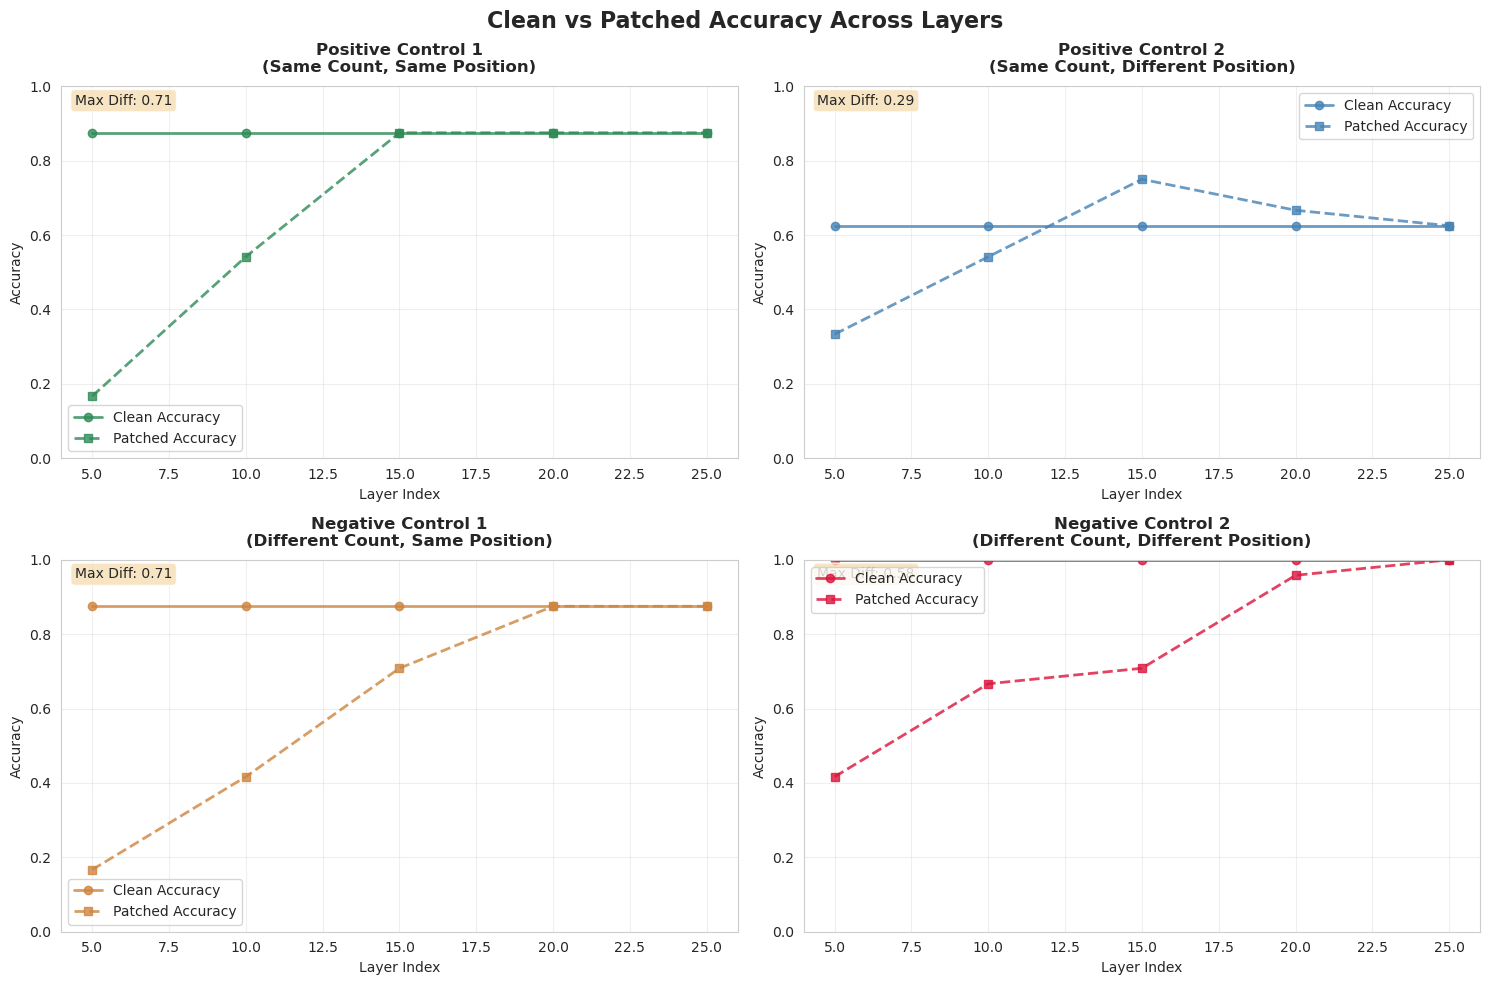

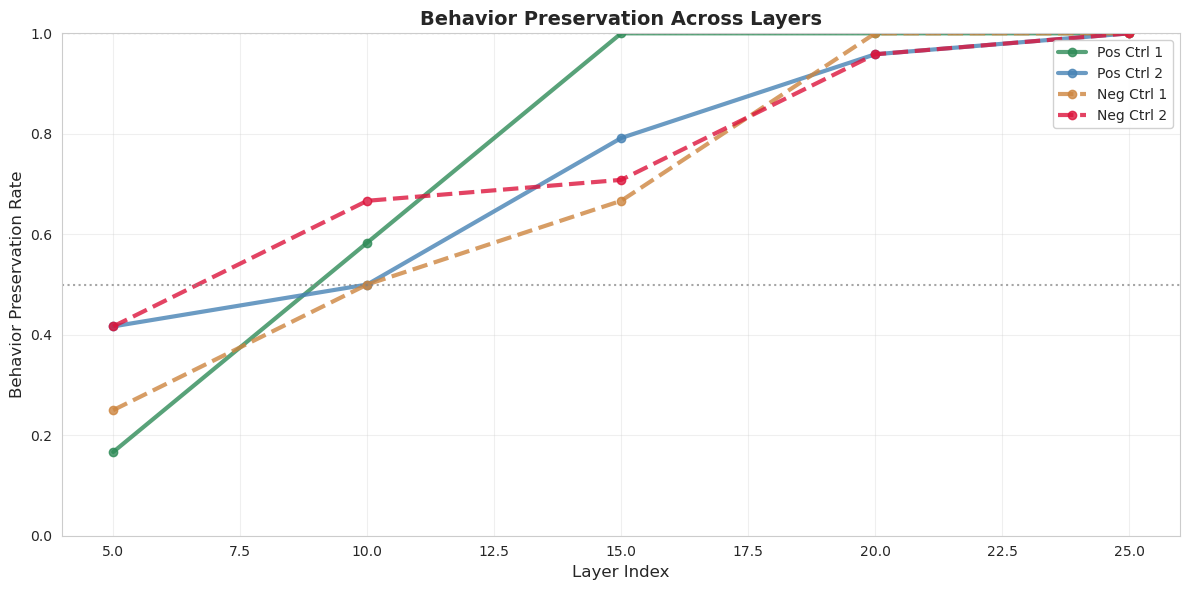

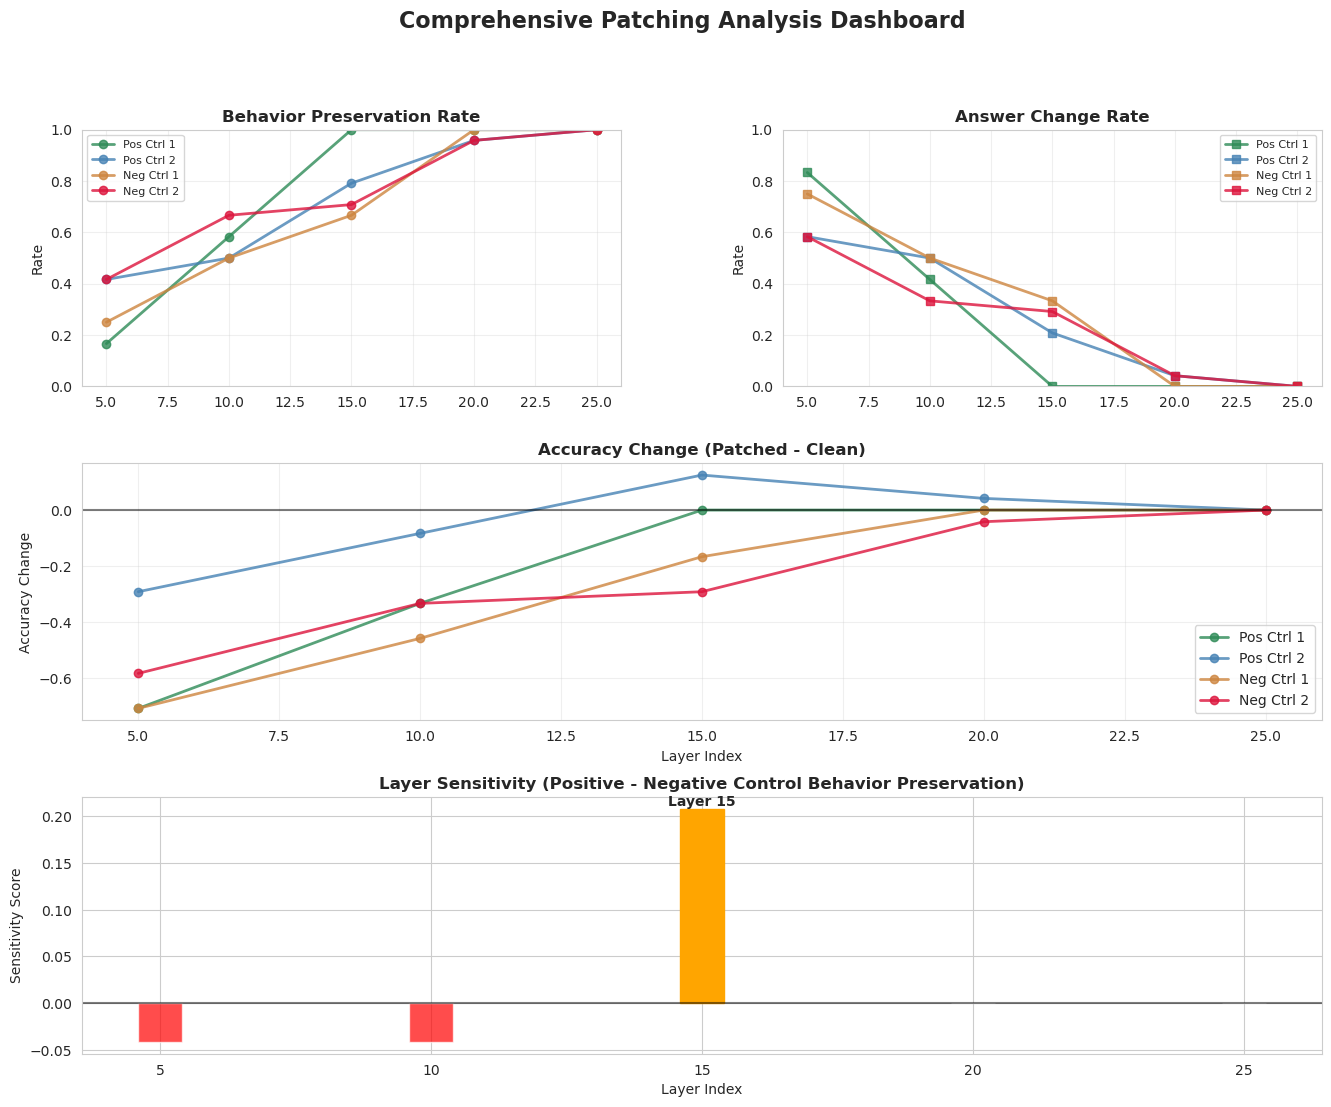

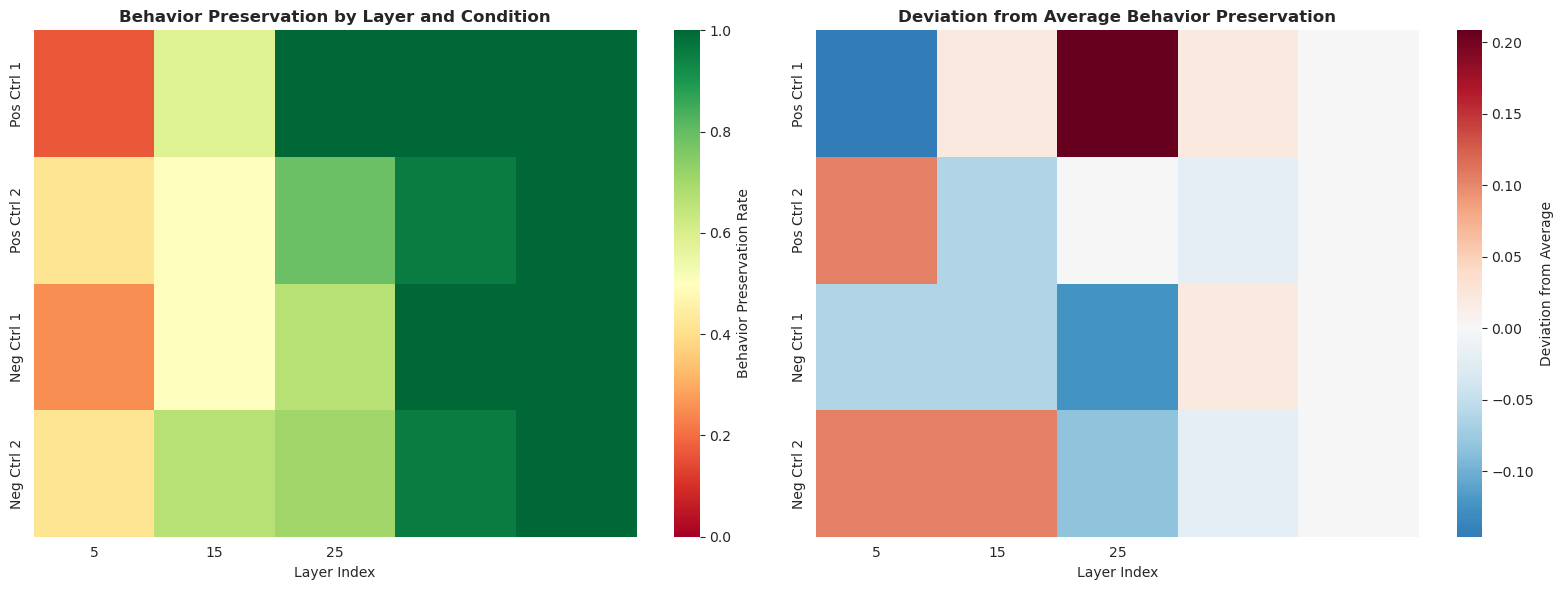

In [65]:
# Example usage (uncomment when you have results):
plot_patching_results(all_results)